# Capstone: Philosophical Factors for NLP
**_Measuring Similarity to Philosophical Concepts in Text Data_**

## Thomas W. Ludlow, Jr.
**General Assembly Data Science Immersive DSI-NY-6**

**February 12, 2019**

# Notebook 4 - Multiclass Classifier Models

### Table of Contents

[**4.1 Data Preparation**](#4.1-Data-Preparation)
- [4.1.1 Define X and y](#4.1.1-Define-X-and-y)
- [4.1.2 Standardize and Weight](#4.1.2-Standardize-and-Weight)

[**4.2 Logistic Regression**](#4.2-Logistic-Regression)
- [4.2.1 Logistic Regression Assembly](#4.2.1-Logistic-Regression-Assembly)
- [4.2.2 Logistic Regression Optimization](#4.2.2-Logistic-Regression-Optimization)

[**4.3 Multinomial Naive Bayes**](#4.3-Multinomial-Naive-Bayes)
- [4.3.1 Multinomial Naive Bayes Assembly](#4.3.1-Multinomial-Naive-Bayes-Assembly)
- [4.3.2 Multinomial Naive Bayes Optimization](#4.3.2-Multinomial-Naive-Bayes-Optimization)

[**4.4 Recurrent Neural Net**](#4.4-Recurrent-Neural-Net)
- [4.4.1 Keras FFRNN Assembly](#4.4.1-Keras-FFRNN-Assembly)
- [4.4.2 Keras FFRNN Optimization](#4.4.2-Keras-FFRNN-Optimization)

**Libraries**

In [134]:
# Python Data Science
import re
import time
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm

# Natural Language Processing
import spacy
import gensim
import pyLDAvis.gensim
from gensim.corpora import Dictionary
from gensim.models import TfidfModel, ldamulticore, CoherenceModel

# Modeling Prep
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import class_weight

# Neural Net
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

# Override deprecation warnings
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

## 4.1 Data Preparation

**Load Train and Test Data**

In [135]:
prep_train = pd.read_csv('../data_vec/prep_train.csv')
prep_test = pd.read_csv('../data_vec/prep_test.csv')

### 4.1.1 Define X and y

In [137]:
X_train = prep_train.drop(['a_num'], axis=1)
X_test = prep_test.drop(['a_num'], axis=1)
y_train = pd.get_dummies(prep_train['a_num'])


In [138]:
prep_test.a_num.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [139]:
adj_y = prep_test.a_num

In [140]:
adj_y += 3

In [141]:
adj_y.unique()

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

In [142]:
adj_y.loc[adj_y[adj_y<=18].index] -= 1 # Sun Tzu

In [143]:
adj_y.loc[adj_y[adj_y<=8].index] -= 1 # Khayyam

In [144]:
adj_y.loc[adj_y[adj_y<=4].index] -= 1 # Hobbes

In [145]:
adj_y.unique()

array([ 0,  1,  2,  3,  5,  6,  7,  9, 10, 11, 12, 13, 14, 15, 16, 17, 19])

In [146]:
adj_y = adj_y.append(pd.Series([4,8,18])).reset_index(drop=True)

In [147]:
y_test = pd.get_dummies(adj_y)

In [148]:
y_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [149]:
y_test.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
8393,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8394,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8395,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8396,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
8397,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [150]:
y_test = y_test.drop([8395, 8396, 8397], axis=0)

### 4.1.2 Standardize and Weight

**Standardize X Features**

In [151]:
ss = StandardScaler()

In [152]:
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [153]:
X_train_sc.shape

(70922, 102)

In [154]:
X_test_sc.shape

(8395, 102)

In [155]:
y_train.shape

(70922, 20)

In [156]:
y_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [157]:
y_test.shape

(8395, 20)

In [158]:
y_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Weights**

In [159]:
c_counts = [sum(y_train.loc[:,i]) for i in range(y_train.shape[1])]

In [160]:
c_counts[:5]

[1118, 3133, 1289, 596, 6513]

In [161]:
c_w_dict = {i:c_counts[i] for i in range(y_train.shape[1])}

In [162]:
c_w_dict

{0: 1118,
 1: 3133,
 2: 1289,
 3: 596,
 4: 6513,
 5: 1657,
 6: 2598,
 7: 6121,
 8: 299,
 9: 9661,
 10: 1181,
 11: 7813,
 12: 5887,
 13: 4186,
 14: 2674,
 15: 3172,
 16: 3520,
 17: 6295,
 18: 2097,
 19: 1112}

In [163]:
lda_train = pd.read_csv('../data_vec/lda_train.csv')
    

In [166]:
sample_weights = [500/c_w_dict[a_num] for a_num in lda_train.a_num]

In [167]:
sample_weights = np.array(sample_weights)

In [168]:
sample_weights[:5]

array([0.44722719, 0.44722719, 0.44722719, 0.44722719, 0.44722719])

## 4.2 Logistic Regression

### 4.2.1 Logistic Regression Assembly

In [98]:
lr_runs = pd.DataFrame(columns=['train_accuracy','test_accuracy', 'params'])

In [99]:
lr_single = {}

In [100]:
logreg = LogisticRegression(random_state=211, n_jobs=3)

In [101]:
logreg.fit(X_train_sc, y_train, sample_weight=sample_weights)

ValueError: bad input shape (70922, 20)

In [ ]:
lr_single['train_accuracy'] = logreg.score(X_train_sc, y_train)
lr_single['test_accuracy'] = logreg.score(X_test_sc, y_test)
lr_single['params'] = logreg.best_params_

### 4.2.2 Logistic Regression Optimization

**Parameters**

In [95]:
lr_params = {
    'penalty':['l1','l2'],
    'C':[0.1, 1, 10]
}

In [107]:
grid = GridSearchCV(logreg, lr_params, cv=3)
grid.fit(X_train_sc, y_train)
lr_single['train_accuracy'] = grid.score(X_train_sc, y_train)
lr_single['test_accuracy'] = grid.score(X_test_sc, y_test)
lr_single['params'] = grid.best_params_

In [ ]:
lr_runs = lr_runs.append(lr_single)

**Save Final Logistic Regression to Disk**

In [ ]:
joblib.dump(logreg, './models/logreg')
 
# some time later...
 
# load the model from disk
#logreg = joblib.load('./models/logreg')

## 4.3 Multinomial Naive Bayes

### 4.3.1 Multinomial Naive Bayes Assembly

In [102]:
mnb_runs = pd.DataFrame(columns=['train_accuracy','test_accuracy','params'])

In [103]:
mnb = MultinomialNB()

### 4.3.2 Multinomial Naive Bayes Optimization

**Parameters**

In [104]:
mnb_params = {
    'alpha':[0.01, 0.1, 0.5, 1, 5, 10]
}

In [105]:
mnb_single = {}

In [106]:
grid = GridSearchCV(mnb, mnb_params, cv=3)
grid.fit(X_train_sc, y_train)
mnb_single['train_accuracy'] = grid.score(X_train_sc, y_train)
mnb_single['test_accuracy'] = grid.score(X_test_sc, y_test)
mnb_single['params'] = grid.best_params_

ValueError: bad input shape (47281, 20)

In [ ]:
mnb_runs = mnb_runs.append(mnb_single)

**Save Final Multinomial Naive Bayes to Disk**

In [ ]:
joblib.dump(mnb, './models/mnb')
 
# some time later...
 
# load the model from disk
#mnb = joblib.load('./models/mnb')

## 4.4 Recurrent Neural Net

### 4.4.1 Keras FFRNN Assembly

**RNN Parameters**

In [169]:
dropout_pct = .25
dense_1_nodes = 64
dense_2_nodes = 128
dense_3_nodes = 64
target_nodes = 20
epochs = 50
batch_size = 1000
patience = 20

In [170]:
model = Sequential()
model.add(Dense(X_train_sc.shape[0], input_dim=X_train_sc.shape[1], activation='relu'))
model.add(Dropout(dropout_pct))
model.add(Dense(dense_1_nodes, activation='relu'))
model.add(Dropout(dropout_pct))
model.add(Dense(dense_2_nodes, activation='relu'))
model.add(Dropout(dropout_pct))
model.add(Dense(dense_3_nodes, activation='relu'))
model.add(Dense(y_test.shape[1], activation=None))
model.add(Activation(tf.nn.softmax))

In [171]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [172]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=patience, verbose=1, mode='auto')

In [173]:
history = model.fit(X_train_sc, 
                    y_train, 
                    validation_data=(X_test_sc, y_test), 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    callbacks=[early_stop], 
                    sample_weight=np.array(sample_weights)
                   )

Train on 70922 samples, validate on 8395 samples
Epoch 1/50
70922/70922 [==============================] - 10s 139us/step - loss: 0.3369 - acc: 0.2485 - val_loss: 2.9465 - val_acc: 0.1140
Epoch 2/50
70922/70922 [==============================] - 9s 124us/step - loss: 0.2718 - acc: 0.3690 - val_loss: 3.0218 - val_acc: 0.1396
Epoch 3/50
70922/70922 [==============================] - 9s 124us/step - loss: 0.2481 - acc: 0.4053 - val_loss: 3.1534 - val_acc: 0.1229
Epoch 4/50
70922/70922 [==============================] - 9s 124us/step - loss: 0.2307 - acc: 0.4319 - val_loss: 3.2286 - val_acc: 0.1238
Epoch 5/50
70922/70922 [==============================] - 9s 124us/step - loss: 0.2163 - acc: 0.4518 - val_loss: 3.2880 - val_acc: 0.1377
Epoch 6/50
70922/70922 [==============================] - 9s 124us/step - loss: 0.2036 - acc: 0.4714 - val_loss: 3.2095 - val_acc: 0.1501
Epoch 7/50
70922/70922 [==============================] - 9s 124us/step - loss: 0.1943 - acc: 0.4884 - val_loss: 3.1750 - 

**With Sample Weights**

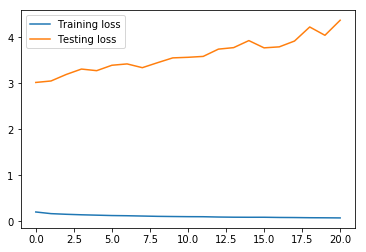

In [132]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Testing loss')
plt.legend()

**Without Sample Weights**

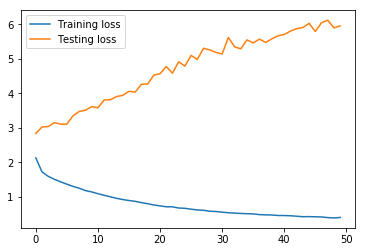

In [83]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Testing loss')
plt.legend()

### 4.4.2 Keras FFRNN Optimization

In [52]:
rnn_opt_params = {
    'dropout_pct' : [.25],
    'dense_1_nodes' : [64,128,256],
    'dense_2_nodes' : [64, 128],
    'dense_3_nodes' : [64],
    'target_nodes' : [20],
    'epochs' : [1],
    'batch_size' : [100],
    'patience' : [1]
}

In [94]:
rnn_df = pd.DataFrame(columns=['dropout_pct','dense_1_nodes','dense_2_nodes',
                               'dense_3_nodes','target_nodes','epochs','batch_size',
                               'patience'])
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

for dp in range(len(tqdm(rnn_opt_params['dropout_pct']))):
    for d1 in range(len(rnn_opt_params['dense_1_nodes'])):
        for d2 in range(len(rnn_opt_params['dense_2_nodes'])):
            for d3 in range(len(rnn_opt_params['dense_3_nodes'])):
                for tn in range(len(rnn_opt_params['target_nodes'])):
                    for e in range(len(rnn_opt_params['epochs'])):
                        for bs in range(len(rnn_opt_params['batch_size'])):
                            for p in range(len(rnn_opt_params['patience'])):
                                temp_df = pd.DataFrame(columns=['dropout_pct','dense_1_nodes','dense_2_nodes',
                                                                'dense_3_nodes','target_nodes','epochs',
                                                                'batch_size','patience'])
                                temp_df.loc['dropout_pct'] = rnn_opt_params['dropout_pct'][dp]
                                temp_df.loc['dense_1_nodes'] = rnn_opt_params['dense_1_nodes'][d1]
                                temp_df.loc['dense_2_nodes'] = rnn_opt_params['dense_2_nodes'][d2]
                                temp_df.loc['dense_3_nodes'] = rnn_opt_params['dense_3_nodes'][d3]
                                temp_df.loc['target_nodes'] = rnn_opt_params['target_nodes'][tn]
                                temp_df.loc['epochs'] = rnn_opt_params['epochs'][e]
                                temp_df.loc['batch_size'] = rnn_opt_params['batch_size'][bs]
                                temp_df.loc['patience'] = rnn_opt_params['patience'][p]
                                
                                model = Sequential()
                                model.add(Dense(X_train_sc.shape[0], input_dim=X_train_sc.shape[1], activation='relu'))
                                model.add(Dropout(dp))
                                model.add(Dense(d1, activation='relu'))
                                model.add(Dropout(dp))
                                model.add(Dense(d2, activation='relu'))
                                model.add(Dropout(dp))
                                model.add(Dense(d3, activation='relu'))
                                model.add(Dense(y_test.shape[1], activation=None))
                                model.add(Activation(tf.nn.softmax))
                                model_full.compile(loss='categorical_crossentropy', 
                                                   optimizer='adam', metrics=['accuracy'])
                                early_stop = EarlyStopping(monitor='val_loss', 
                                                                min_delta=0, patience=p, 
                                                                verbose=1, mode='auto')
                                history = model.fit(X_train_sc, 
                                                    y_train, 
                                                    validation_data=(X_test_sc, y_test), 
                                                    epochs=e, 
                                                    batch_size=bs, 
                                                    callbacks=[early_stop])
                                
                                train_loss_list.append(history.history['loss'])
                                test_loss_list.append(history.history['val_loss'])
                                train_acc_list.append(history.history['acc'])
                                test_acc_list.append(history.history['val_acc'])
                                
                                rnn_df = rnn_df.append(temp_df)
                
rnn_df.head()

**Save Final Keras FFRNN to Disk**

In [84]:
model.save('../ec2_models/rnn')

## Factorizing Text Example

### Preprocessing

In [85]:
# Using medium English library which does not include vectors
nlp = spacy.load('en_core_web_md')

In [ ]:
def preprocess_to_df(par_file, nlp=nlp, sw=['the','a','but','like','for'], to_stem=False):
    # Run spaCy process on each paragraph and store docs in list
    print('nlp of paragraphs...')
    par_nlp = []
    for par in tqdm(par_file.paragraph):
        par_nlp.append(nlp(par))
    
    # Store paragraph lemma from spaCy docs
    print('nlp lemmatizing, part-of-speech, stopwords...')
    par_lemma = []
    for par in tqdm(par_nlp):
        par_lemma.append([token.lemma_ for token in par     # List comprehension
                           if token.lemma_ != '-PRON-'           # Pronouns are excluded
                           and token.pos_ != 'PUNCT'             # Punctionation is excluded
                           and token.is_alpha                    # Numbers are excluded
                           and not token.is_stop                 # Stop words are excluded
                          and len(token.lemma_) > 1])               
    
    # Stem lemma with NLTK PorterStemmer and remove stop words
    print('additional stopwords...')
    if to_stem: ps = PorterStemmer()
    par_lemma_sw = []
    for vec_list in tqdm(par_lemma):    
        update_list = []
        for token in vec_list:
            if token in sw: continue
            if to_stem: update_list.append(ps.stem(token))
            else: update_list.append(token)
        par_lemma_sw.append(update_list)
    
    # Run spaCy on each sentence doc: Text
    print('saving sentence text...')
    sent_text = []
    for par in tqdm(par_nlp):
        sent_list = []
        for s in par.sents:
            sent_list.append(s.text)
        sent_text.append(sent_list)
    
    # Run spaCy on each sentence doc: NLP
    print('nlp of sentences...')
    sent_nlp = []
    for par in tqdm(par_nlp):
        sent_list = []
        for s in par.sents:
            sent_list.append(nlp(s.text))
        sent_nlp.append(sent_list)
    
    # Store lemma from spaCy docs
    print('nlp lemmatizing, part-of-speech, stopwords...')
    sent_lemma = []
    for par in tqdm(sent_nlp):
        for sent in par:
            sent_lemma.append([token.lemma_ for token in sent     # List comprehension
                               if token.lemma_ != '-PRON-'           # Pronouns are excluded
                               and token.pos_ != 'PUNCT'             # Punctionation is excluded
                               and token.is_alpha                    # Numbers are excluded
                               and not token.is_stop                 # Stop words are excluded
                              and len(token.lemma_) > 1])               
    
    # Stem lemma with NLTK PorterStemmer and remove stop words
    print('additional stopwords...')
    if to_stem: ps = PorterStemmer()
    sent_lemma_sw = []
    for vec_list in tqdm(sent_lemma):    
        update_list = []
        for token in vec_list:
            if token in sw: continue
            if to_stem: update_list.append(ps.stem(token))
            else: update_list.append(token)
        sent_lemma_sw.append(update_list)
    
    print('constructing dataframe...')
    nlp_df = pd.DataFrame(columns=['author','work','a_num','w_num','p_num','s_num',
                                    'sent_text','sent_lemma','par_text','par_lemma'])

    a_num = 0
    w_num = 0
    p_num = 0

    for p, sents_in_par in enumerate(tqdm(sent_text)):
        for s, sent in enumerate(sents_in_par):
            nlp_df = nlp_df.append({'author':par_file.loc[p, 'author'], 
                                    'work':par_file.loc[p, 'work'], 
                                    'a_num':a_num,
                                    'w_num':w_num,
                                    'p_num':p_num,
                                    's_num':s,
                                    'sent_text':sent,
                                    'par_text':par_file.loc[p, 'paragraph'],
                                    'par_lemma':par_lemma_sw[p]
                                    }, ignore_index=True)
        p_num += 1
        if p == par_file.shape[0]-1: continue
        if par_file.loc[p,'work'] != par_file.loc[p+1,'work']:
            p_num = 0
            w_num += 1
            if par_file.loc[p,'author'] != par_file.loc[p+1,'author']:
                a_num += 1

    nlp_df['sent_lemma'] = sent_lemma_sw
    print('complete')
    return nlp_df

In [ ]:
def nlp_factorize(lda_df, model=model_full, ss=ss):
    lda_sc = ss.transform(lda_df.values)    
    preds = model.predict_proba(lda_sc)
    return preds

### Display Results

In [ ]:
def display_nlp_factors(preds, raw_text, doc_number=0, thresh=0.01, target_authors=None):
    print('-'*30)
    print('Doc #:', doc_number)
    if target_authors: print('Target Author:', target_authors[doc_number])
    print('Text:\n', raw_text[doc_number])
    print('\nPhilosophical Factors:\n')
    
    result_list = [(text_data.Author.unique()[i], preds[doc_number][i]) for i in range(len(text_data.Author.unique()))]
    result_list.sort(key=lambda tup: tup[1], reverse=True)
    
    for j in range(len(text_data.Author.unique())):
        n_sp = 35 - len(result_list[j][0])
        if result_list[j][1] >= thresh:
            print('\t{}{}{}'.format(result_list[j][0],str(' '*n_sp),str(round(result_list[j][1], 3))))
    print('-'*30)

In [133]:
babbage = """
There are few circumstances which so strongly distinguish the philosopher, 
as the calmness with which he can reply to criticisms he may think...
"""

## Continue to Notebook 5: Factorizing Unseen Text